In [1]:
"""Importing the required packages"""
import random
import collections
import math
import os
import zipfile
import time
import re 

import numpy as np
import tensorflow as tf

from matplotlib import pylab
%matplotlib inline

from six.moves import range
from six.moves.urllib.request import urlretrieve

from tensorflow.contrib.tensorboard.plugins import projector
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

E:\anaconda\envs\tensorFlow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
"""Make sure the dataset link is copied correctly"""

dataset_link = 'http://mattmahoney.net/dc/'
zip_file = 'text8.zip'

def data_download(zip_file):
    """Downloading the required file"""
    if not os.path.exists(zip_file):
        zip_file, _ = urlretrieve(dataset_link + zip_file, zip_file)
        print('File downloaded successfully!')
    return None

data_download(zip_file)

File downloaded successfully!


In [3]:

"""Extracting the dataset in separate folder"""
extracted_folder = 'dataset'

if not os.path.isdir(extracted_folder):
    with zipfile.ZipFile(zip_file) as zf:
        zf.extractall(extracted_folder)

In [4]:
with open('dataset/text8') as ft_ :
    full_text = ft_.read()

In [5]:
def text_processing(ft8_text):
    """Replacing punctuation marks with tokens"""
    ft8_text = ft8_text.lower()
    ft8_text = ft8_text.replace('.', ' <period> ')
    ft8_text = ft8_text.replace(',', ' <comma> ')
    ft8_text = ft8_text.replace('"', ' <quotation> ')
    ft8_text = ft8_text.replace(';', ' <semicolon> ')
    ft8_text = ft8_text.replace('!', ' <exclamation> ')
    ft8_text = ft8_text.replace('?', ' <question> ')
    ft8_text = ft8_text.replace('(', ' <paren_l> ')
    ft8_text = ft8_text.replace(')', ' <paren_r> ')
    ft8_text = ft8_text.replace('--', ' <hyphen> ')
    ft8_text = ft8_text.replace(':', ' <colon> ')
    ft8_text_tokens = ft8_text.split()
    
    return ft8_text_tokens

In [6]:
ft_tokens = text_processing(full_text)
"""Shortlisting words with frequency more than 7"""
word_cnt = collections.Counter(ft_tokens)
shortlisted_words = [w for w in ft_tokens if word_cnt[w] > 7 ]

In [7]:
print(shortlisted_words[:15])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including']


In [8]:
print("Total number of shortlisted words : ",len(shortlisted_words))
print("Unique number of shortlisted words : ",len(set(shortlisted_words)))#set()集合 刪除其中重複的元素

Total number of shortlisted words :  16616688
Unique number of shortlisted words :  53721


In [9]:
def dict_creation(shortlisted_words):
    """The function creates a dictionary of the words present in dataset along with their frequency order"""
    counts = collections.Counter(shortlisted_words)   #可以獲取出現詞的次數
    vocabulary = sorted(counts, key=counts.get, reverse=True)  #默認升序，reverse=True降序
    rev_dictionary_ = {ii: word for ii, word in enumerate(vocabulary)}
    dictionary_ = {word: ii for ii, word in rev_dictionary_.items()}
    return dictionary_, rev_dictionary_

In [10]:
dictionary_, rev_dictionary_ = dict_creation(shortlisted_words)
words_cnt = [dictionary_[word] for word in shortlisted_words]

In [ ]:
'''=====================================skip-gram========================================'''

In [11]:
"""Creating the threshold and performing the subsampling"""
thresh = 0.00005
word_counts = collections.Counter(words_cnt)     #會返回一個集合，是dict的subclass 像一個multilist  元素儲存為k，出現的次數儲存為v
total_count = len(words_cnt)                     #總詞數
freqs = {word: count / total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(thresh/freqs[word]) for word in word_counts}     #skip-gram公式
train_words = [word for word in words_cnt if p_drop[word] < random.random()]

In [12]:
def skipG_target_set_generation(batch_, batch_index, word_window): 
    """The function combines the words of given word_window size next to the index, for the SkipGram model"""
    random_num = np.random.randint(1, word_window+1)
    words_start = batch_index - random_num if (batch_index - random_num) > 0 else 0
    words_stop = batch_index + random_num
    window_target = set(batch_[words_start:batch_index] + batch_[batch_index+1:words_stop+1])
    return list(window_target)

In [13]:
def skipG_batch_creation(short_words, batch_length, word_window):
    """The function internally makes use of the skipG_target_set_generation() function and combines each of the label 
    words in the shortlisted_words with the words of word_window size around"""
    batch_cnt = len(short_words)//batch_length
    short_words = short_words[:batch_cnt*batch_length]  
    
    for word_index in range(0, len(short_words), batch_length):
        input_words, label_words = [], []
        word_batch = short_words[word_index:word_index+batch_length]
        for index_ in range(len(word_batch)):
            batch_input = word_batch[index_]
            batch_label = skipG_target_set_generation(word_batch, index_, word_window)
            # Appending the label and inputs to the initial list. Replicating input to the size of labels in the window 
            label_words.extend(batch_label)
            input_words.extend([batch_input]*len(batch_label))
        yield input_words, label_words

In [14]:
tf_graph = tf.Graph()
with tf_graph.as_default():
    input_ = tf.placeholder(tf.int32, [None], name='input_')
    label_ = tf.placeholder(tf.int32, [None, None], name='label_')

with tf_graph.as_default():
    word_embed = tf.Variable(tf.random_uniform((len(rev_dictionary_), 300), -1, 1))    #定義word_embed為變量tensor
    embedding = tf.nn.embedding_lookup(word_embed, input_)

In [15]:
"""
 The code includes the following  :
 # Initializing weights and bias to be used in the softmax layer
 # Loss function calculation using the Negative Sampling
 # Usage of Adam Optimizer
 # Negative sampling on 100 words, to be included in the loss function
 # 300 is the word embedding vector size
 
"""
vocabulary_size = len(rev_dictionary_)

with tf_graph.as_default():
    sf_weights = tf.Variable(tf.truncated_normal((vocabulary_size, 300), stddev=0.1) )     #初始化權重weights  維度：300  標準差：0.1 
    sf_bias = tf.Variable(tf.zeros(vocabulary_size) )                                      #初始化偏差bias

    loss_fn = tf.nn.sampled_softmax_loss(weights=sf_weights, biases=sf_bias,               #tf中的一個loss fuction  Negative Sampling
                                         labels=label_, inputs=embedding, 
                                         num_sampled=100, num_classes=vocabulary_size)
    cost_fn = tf.reduce_mean(loss_fn)
    optim = tf.train.AdamOptimizer().minimize(cost_fn)                                      #優化器 adam

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [16]:
"""The below code performs the following operations :
 # Performing validation here by making use of a random selection of 16 words from the dictionary of desired size
 # Selecting 8 words randomly from range of 1000    
 # Using the cosine distance to calculate the similarity between the words 
"""
with tf_graph.as_default():    
    validation_cnt = 16
    validation_dict = 100
    
    validation_words = np.array(random.sample(range(validation_dict), validation_cnt//2))                   #validation_dict中選8個
    validation_words = np.append(validation_words, random.sample(range(1000,1000+validation_dict), validation_cnt//2)) #不常見詞選8個
    validation_data = tf.constant(validation_words, dtype=tf.int32)

    normalization_embed = word_embed / (tf.sqrt(tf.reduce_sum(tf.square(word_embed), 1, keep_dims=True)))
    validation_embed = tf.nn.embedding_lookup(normalization_embed, validation_data)    #獲取這個tensor 中的索引
    word_similarity = tf.matmul(validation_embed, tf.transpose(normalization_embed))   #矩陣相乘

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [17]:
"""Creating the model checkpoint directory"""
!mkdir model_checkpoint

In [18]:
epochs = 2            # Increase it as per computation resources. It has been kept low here for users to replicate the process, increase to 100 or more
batch_length = 1000
word_window = 10

with tf_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=tf_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = skipG_batch_creation(train_words, batch_length, word_window)
        start = time.time()
        for x, y in batches:
            train_loss, _ = sess.run([cost_fn, optim], 
                                     feed_dict={input_: x, label_: np.array(y)[:, None]})
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs), ", Iteration: {}".format(iteration),
                      ", Avg. Training loss: {:.4f}".format(loss/100),", Processing : {:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 2000 == 0:
                similarity_ = word_similarity.eval()
                for i in range(validation_cnt):
                    validated_words = rev_dictionary_[validation_words[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-similarity_[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % validated_words
                    for k in range(top_k):
                        close_word = rev_dictionary_[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "model_checkpoint/skipGram_text8.ckpt")
    embed_mat = sess.run(normalization_embed)

Epoch 1/2 , Iteration: 100 , Avg. Training loss: 6.1620 , Processing : 0.4359 sec/batch
Epoch 1/2 , Iteration: 200 , Avg. Training loss: 6.1442 , Processing : 0.4258 sec/batch
Epoch 1/2 , Iteration: 300 , Avg. Training loss: 6.1289 , Processing : 0.4350 sec/batch
Epoch 1/2 , Iteration: 400 , Avg. Training loss: 6.0201 , Processing : 0.4389 sec/batch
Epoch 1/2 , Iteration: 500 , Avg. Training loss: 5.9278 , Processing : 0.4339 sec/batch
Epoch 1/2 , Iteration: 600 , Avg. Training loss: 5.9563 , Processing : 0.4317 sec/batch
Epoch 1/2 , Iteration: 700 , Avg. Training loss: 5.8230 , Processing : 0.4230 sec/batch
Epoch 1/2 , Iteration: 800 , Avg. Training loss: 5.7558 , Processing : 0.4242 sec/batch
Epoch 1/2 , Iteration: 900 , Avg. Training loss: 5.6621 , Processing : 0.4257 sec/batch
Epoch 1/2 , Iteration: 1000 , Avg. Training loss: 5.5900 , Processing : 0.4314 sec/batch
Epoch 1/2 , Iteration: 1100 , Avg. Training loss: 5.4267 , Processing : 0.4321 sec/batch
Epoch 1/2 , Iteration: 1200 , 

Epoch 1/2 , Iteration: 6000 , Avg. Training loss: 4.5748 , Processing : 0.4446 sec/batch
Nearest to new: mainstay, aeon, saronic, rushing, mitral, mmds, national, billionaire,
Nearest to two: launched, hildebrand, burali, six, congress, ubuweb, lofty, vigil,
Nearest to these: homeomorphic, covalently, amidah, heresy, denoted, africans, unicellular, reggaeton,
Nearest to th: smoothed, harsh, codex, goths, baruch, greeks, four, booed,
Nearest to have: superseding, batsford, holomorphic, forebears, endeavouring, aspired, meteors, tombaugh,
Nearest to over: mouthpieces, acf, banaba, partition, bodied, democrats, leyland, spring,
Nearest to the: xo, huddle, hire, sensors, derailed, sinful, unanimous, nitrides,
Nearest to about: affleck, kuro, admiralty, lived, campaigning, kangra, plasticity, sanj,
Nearest to alternative: catalogues, acids, humans, socially, subtext, subversion, students, mudslides,
Nearest to police: councillors, tropes, cavour, kulak, dendrites, nutshell, labeling, jozef,

Epoch 2/2 , Iteration: 10300 , Avg. Training loss: 4.2372 , Processing : 0.4279 sec/batch
Epoch 2/2 , Iteration: 10400 , Avg. Training loss: 4.2744 , Processing : 0.4372 sec/batch
Epoch 2/2 , Iteration: 10500 , Avg. Training loss: 4.3006 , Processing : 0.4133 sec/batch
Epoch 2/2 , Iteration: 10600 , Avg. Training loss: 4.2750 , Processing : 0.4142 sec/batch
Epoch 2/2 , Iteration: 10700 , Avg. Training loss: 4.3188 , Processing : 0.4161 sec/batch
Epoch 2/2 , Iteration: 10800 , Avg. Training loss: 4.2765 , Processing : 0.4135 sec/batch
Epoch 2/2 , Iteration: 10900 , Avg. Training loss: 4.3087 , Processing : 0.4153 sec/batch
Epoch 2/2 , Iteration: 11000 , Avg. Training loss: 4.2669 , Processing : 0.4107 sec/batch
Epoch 2/2 , Iteration: 11100 , Avg. Training loss: 4.3178 , Processing : 0.4140 sec/batch
Epoch 2/2 , Iteration: 11200 , Avg. Training loss: 4.2843 , Processing : 0.4139 sec/batch
Epoch 2/2 , Iteration: 11300 , Avg. Training loss: 4.1951 , Processing : 0.4146 sec/batch
Epoch 2/2 

In [19]:
"""The Saver class adds ops to save and restore variables to and from checkpoints."""
with tf_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=tf_graph) as sess:
    """Restoring the trained network"""
    saver.restore(sess, tf.train.latest_checkpoint('model_checkpoint'))
    embed_mat = sess.run(word_embed)

INFO:tensorflow:Restoring parameters from model_checkpoint\skipGram_text8.ckpt


In [35]:
word_graph = 200
tsne = TSNE()       #t-SNE降維 for可視化
word_embedding_tsne = tsne.fit_transform(embed_mat[:word_graph, :])     #  fit	將x投射到一個嵌入空間
                                                                        #fit_transform	將x投射到一個嵌入空間並會返回轉換結果

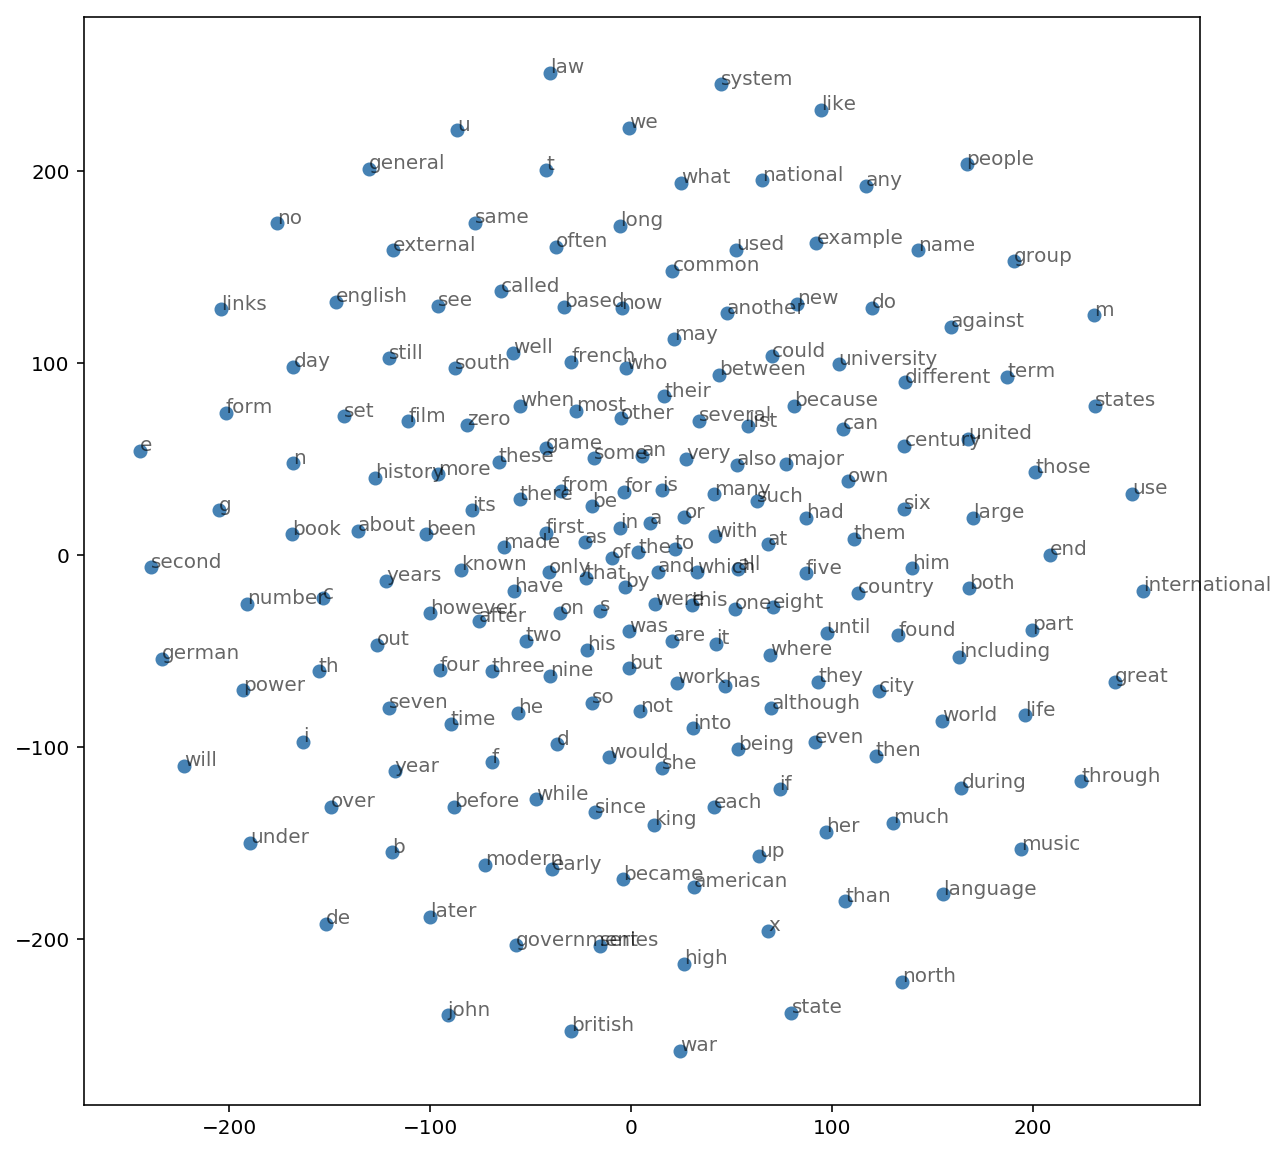

In [36]:
fig, ax = plt.subplots(figsize=(10, 10))
for idx in range(word_graph):
    plt.scatter(*word_embedding_tsne[idx, :], color='steelblue')                        #散點圖
    plt.annotate(rev_dictionary_[idx], (word_embedding_tsne[idx, 0], word_embedding_tsne[idx, 1]), alpha=0.6)   #對每個散點注釋單詞

In [25]:
#optional
#with open(os.path.join('model_checkpoint', "metainfo.tsv"), 'w') as f:
#    for i in range(len(rev_dictionary_)):
#        f.write(rev_dictionary_[i] + '\n')

In [26]:
#optional
#summary_writer = tf.summary.FileWriter('model_checkpoint', sess.graph)

#config = projector.ProjectorConfig()
#embedding_conf = config.embeddings.add()
#embedding_conf.metadata_path = os.path.join('model_checkpoint', 'metainfo.tsv')
#projector.visualize_embeddings(summary_writer, config)